In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

<AxesSubplot:>

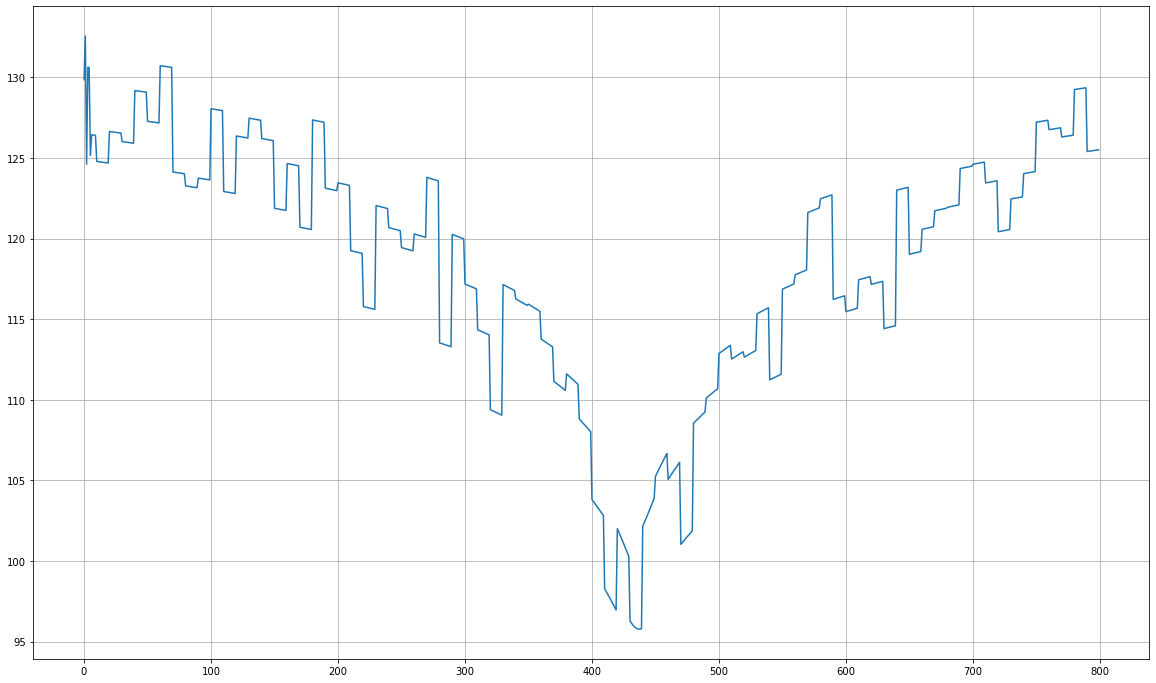

In [2]:
df = pd.read_csv("/home/smsung/Downloads/MilliCar-SUMO/Test/Test_data_220120/cv_s60_i2.5_k0.8606_a0.7656_l_R_Urban.txt",sep='\t', names=['seq','speed','IR','Pathloss','dist','WA','WC','Sc'])

pathloss = df['Pathloss']
pathloss.plot(figsize=(20,12), grid=True) #plotting



In [4]:
X = df.drop(columns='Sc') 
pathloss = df.iloc[:,3:4] 
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['seq','speed','IR','Pathloss','dist','WA','WC']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled
pathloss

,Pathloss
0,129.856
1,132.552
2,124.614
3,130.620
4,130.610
...,...
795,125.457
796,125.469
797,125.481
798,125.493


In [5]:
TEST_SIZE = 20
WINDOW_SIZE = 10

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [6]:
def make_dataset(data, label, window_size=5):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
from sklearn.model_selection import train_test_split

feature_cols = ['seq','dist','Pathloss']
label_cols = ['Pathloss']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 1)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)
x_train.shape, x_valid.shape

((545, 1, 3), (234, 1, 3))

In [8]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((20, 3), (20, 1))

In [9]:
test_feature, test_label = make_dataset(test_feature, test_label, 1)
test_feature.shape, test_label.shape

((19, 1, 3), (19, 1))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [11]:
import os

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

hist = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Train on 545 samples, validate on 234 samples
Epoch 1/200
256/545 [=============>................] - ETA: 1s - loss: 0.3376 - accuracy: 0.0000e+00 
Epoch 00001: val_loss improved from inf to 0.24321, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 2s 3ms/sample - loss: 0.3055 - accuracy: 0.0018 - val_loss: 0.2432 - val_accuracy: 0.0000e+00
Epoch 2/200
256/545 [=============>................] - ETA: 0s - loss: 0.2330 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 0.24321 to 0.13427, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 0s 276us/sample - loss: 0.1933 - accuracy: 0.0018 - val_loss: 0.1343 - val_accuracy: 0.0000e+00
Epoch 3/200
464/545 [========================>.....] - ETA: 0s - loss: 0.0989 - accuracy: 0.0022  
Epoch 00003: val_loss improved from 0.13427 to 0.05471, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 0s 463us/sample - loss: 0.0949 - accuracy: 0.0018

Epoch 26/200
368/545 [===================>..........] - ETA: 0s - loss: 0.0023 - accuracy: 0.0027    
Epoch 00026: val_loss improved from 0.00197 to 0.00189, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 0s 226us/sample - loss: 0.0023 - accuracy: 0.0018 - val_loss: 0.0019 - val_accuracy: 0.0043
Epoch 27/200
352/545 [==================>...........] - ETA: 0s - loss: 0.0021 - accuracy: 0.0000e+00    
Epoch 00027: val_loss improved from 0.00189 to 0.00185, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 0s 232us/sample - loss: 0.0023 - accuracy: 0.0018 - val_loss: 0.0018 - val_accuracy: 0.0043
Epoch 28/200
352/545 [==================>...........] - ETA: 0s - loss: 0.0022 - accuracy: 0.0028    
Epoch 00028: val_loss improved from 0.00185 to 0.00183, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 0s 230us/sample - loss: 0.0022 - accuracy: 0.0018 - val_loss: 0.0018 - val_accuracy: 0.00

Epoch 52/200
288/545 [==============>...............] - ETA: 0s - loss: 0.0012 - accuracy: 0.0000e+00    
Epoch 00052: val_loss did not improve from 0.00137
545/545 [==============================] - 0s 243us/sample - loss: 0.0014 - accuracy: 0.0018 - val_loss: 0.0014 - val_accuracy: 0.0043
Epoch 53/200
320/545 [================>.............] - ETA: 0s - loss: 0.0015 - accuracy: 0.0000e+00    
Epoch 00053: val_loss did not improve from 0.00137
545/545 [==============================] - 0s 259us/sample - loss: 0.0015 - accuracy: 0.0018 - val_loss: 0.0014 - val_accuracy: 0.0043
Epoch 54/200
528/545 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.0019        
Epoch 00054: val_loss improved from 0.00137 to 0.00136, saving model to model/tmp_checkpoint.h5
545/545 [==============================] - 0s 291us/sample - loss: 0.0014 - accuracy: 0.0018 - val_loss: 0.0014 - val_accuracy: 0.0043
Epoch 55/200
320/545 [================>.............] - ETA: 0s - loss: 0.0014 

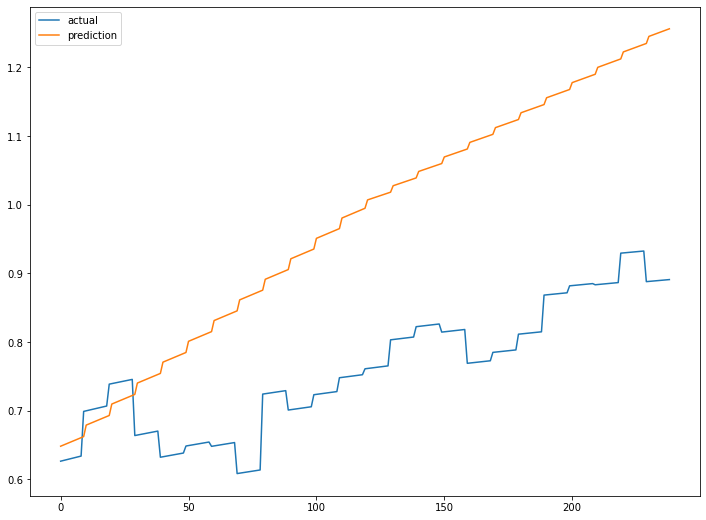

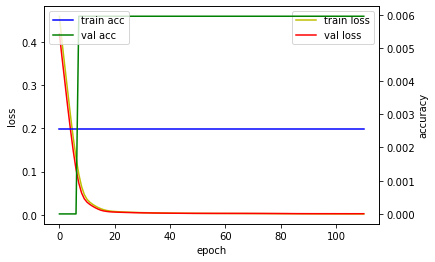

In [52]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()